# Notebook 2
## Model usage with real photos
In this notebbok the trained model is used to do face detection inside real photos. 

Model is imported from file through joblib module, and then is used with sliding window technique.
Face detection results are shown with bounding boxes overlaid on original photo, in a similar way as in a digital camera screen.

In this notebook all the script is written in python (there isn't a bash section like in Notebbok 1).

In [45]:
#Import some modules
import joblib
from tqdm import tqdm
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.exposure import rescale_intensity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from ImageResizer import ImageResizer
from HOGFeatureExtractor import HOGFeatureExtractor
from skimage.exposure import equalize_hist
from skimage.color import rgb2gray


### Utility functions

In [46]:
def sliding_window(image, step_size, window_size):
    """
    Sliding window implementation. 
    This function returns an iterator that yelds several sliding windows, moving on
    input image.

    Parameters:
    - image: (M,N) ndarray
        The input image as numpy array. The image must be grayscale.
    - step_size: int
        Displacement (in pixel) between a sliding window and next one, both on
        horizontal and vertical axis.
    - window_size: 2-d tuple (int, int)
        Sliding window shape, as (width, height) in pixel.
    
    Return:
    iterator that yelds a tuple (x, y, sliding_window):
    - x, y: int
        coordinates of top left corner of current sliding window.
    - sliding_window: 2d numpy array.
        The current sliding window.
    """
    # get the window and image sizes
    w, h = window_size
    image_h, image_w = image.shape[:2]

    # loop over the image, taking steps of size `step_size`
    for y in range(0, image_h, step_size):
        for x in range(0, image_w, step_size):
            # define the window
            window = image[y:y + h, x:x + w]
            # if the window is below the minimum window size, ignore it
            if window.shape[:2] != window_size:
                continue
            # yield the current window
            yield (x, y, window)

In [47]:
def compute_iou(box, other_boxes):
    """
    Computes Intersection over Union, between a bounding box and all other boxes.
    This is used in non-max suppression algorithm.

    Parameters:
    - box: 4-d array-like of int.
        List of main bounding box coordinates as [x1, y1,, x2, y2], where (x1, y1) are
        coordinates of top left corner and (x2, y2) are coordinates of bottom right corner.
    - other_boxes: (N,4) ndarray.
        List of other boxes, used to compute IoU respect to main box.
        Each row of this matrix is a 4-d array of boxes coordinates [x1, y1, x2, y2],
        with same meaning as 'box' parameter.

    Return:
    iou as float.    
    """
    x1 = np.maximum(box[0], other_boxes[:, 0])
    y1 = np.maximum(box[1], other_boxes[:, 1])
    x2 = np.minimum(box[2], other_boxes[:, 2])
    y2 = np.minimum(box[3], other_boxes[:, 3])
    
    inter_area = np.maximum(0, x2 - x1 + 1) * np.maximum(0, y2 - y1 + 1)
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    other_areas = (other_boxes[:, 2] - other_boxes[:, 0] + 1) * (other_boxes[:, 3] - other_boxes[:, 1] + 1)
    
    iou = inter_area / (box_area + other_areas - inter_area)
    return iou


In [53]:
def non_max_suppression(boxes, scores, threshold = 0.5):
    """
    Non-max suppression algorithm implementation.
    This algorithm filters detected bounding boxes, to keep only relevant ones when they overlap.

    Parameters:
    - boxes: (N,4) array-like
        List of detected bounding boxes, to be processed.
        Each row of this matrix is a 4-d array of boxes coordinates [x1, y1, x2, y2],
        where (x1, y1) are coordinates of top left corner and (x2, y2) are coordinates of bottom right corner.
    - scores: list of int with length N
        List of scores associated to bounding boxes; i-th element refers to i-th row in 'boxes' parameter.
    - threshold: float, default = 0.5
        Threshold used to determine if discard a box or not.
        Boxes with IoU (Intersection over union) > threshold are discarded.

    Return:
    sublist of 'boxes' containing only valid boxes after filtering.
    """
    # Converti le liste in array numpy per una manipolazione più semplice
    
    boxes = np.array(boxes)
    scores = np.array(scores)
    
    # Ordina i box in base ai punteggi in ordine decrescente
    indices = np.argsort(scores)[::-1]
    boxes = boxes[indices]    
    keep = []
    
    while len(boxes) > 0:
        # Prendi il box con il punteggio più alto
        current_box = boxes[0]
        keep.append(current_box)
        
        # Calcola l'IoU tra il box corrente e tutti gli altri box
        other_boxes = boxes[1:]
        iou = compute_iou(current_box, other_boxes)
        print("iou")
        print(iou.shape)
        print(iou)
        # Mantieni solo i box con IoU inferiore alla soglia
        boxes = other_boxes[iou < threshold]
    
    return keep


### Main Script

#### Pipeline import

In [49]:

pipeline = joblib.load(filename="model.joblib")
pipeline

Pipeline(memory='pipe_cache',
         steps=[('resizer', ImageResizer(resize_shape=(64, 64))),
                ('hog', HOGFeatureExtractor()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=200, random_state=200)),
                ('svc', SVC(C=49.41536292718904, max_iter=5000))])

#### Model testing with real photos

Pyramid shape: (4000, 2256)
Pyramid shape: (2000, 1128)
Pyramid shape: (1000, 564)
Pyramid shape: (500, 282)
	Face detected at (100, 240)
Pyramid shape: (250, 141)
Pyramid shape: (125, 71)
Pyramid shape: (63, 36)
Breaking loop
Non max suppression
iou
(0,)
[]


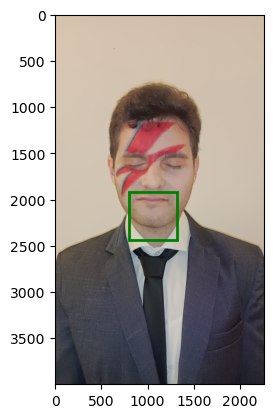

In [58]:
image_or = imread("img1.jpg")
image = rgb2gray(image_or)
# image = equalize_hist(image)
# w, h = 64, 128
w, h = 64, 64
bounding_boxes = []
boxes = []
scores = []
downscale = 2

for resized_img in pyramid_gaussian(image, downscale=downscale):
    print(f"Pyramid shape: {resized_img.shape}")
    if resized_img.shape[0] < h or resized_img.shape[1] < w:
        print("Breaking loop")
        break

    for (x_win, y_win, window) in sliding_window(resized_img, step_size=20, window_size=(w, h)):
        prediction = pipeline.predict(window)
        # print(pipeline.decision_function(window))
        #replace with saving bounding box info
        if(prediction[0] == 1):
            print(f"\tFace detected at ({x_win}, {y_win})")
            scale_factor = image.shape[0]/resized_img.shape[0]
            x_original = int(x_win*scale_factor)
            y_orignal = int(y_win*scale_factor)
            width_orignal = int(w*scale_factor)
            height_oringal = int(h*scale_factor)
            bounding_boxes.append((x_original,y_orignal,width_orignal,height_oringal)) # (x, y, width, height)
            boxes.append([x_original, y_orignal, x_original + width_orignal, y_orignal + height_oringal]) # [x1, y1, x2, y2]
            scores.append(pipeline.decision_function(window)[0])


print("Non max suppression")
boxes_filtered = non_max_suppression(boxes=boxes, scores=scores, threshold=0.2)

import matplotlib.patches as patches
#display bounding boxes inside image
plt.imshow(image_or)
# for (x_box, y_box, width, height) in bounding_boxes:
#     rect = patches.Rectangle((x_box, y_box), width, height, linewidth=2, edgecolor='g', facecolor='none')
#     plt.gca().add_patch(rect)

for [x1, y1, x2, y2] in boxes_filtered:
    width = x2 -x1 + 1
    height = y2 - y1 + 1
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='g', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

#### TODO: delete cells below

In [51]:
b = np.array(boxes)
print(b.shape)

(9, 4)


In [52]:
scores

[0.03421307809194096,
 0.2699042452477881,
 0.08391634241847912,
 0.009149883830769312,
 0.08199559731471329,
 0.09049846351751123,
 0.23479745312245381,
 0.0862546974350652,
 0.3785372580354377]